# MNIST

In [1]:
from sklearn.datasets import fetch_mldata
from matplotlib import pyplot as plt
import numpy as np
%matplotlib notebook

In [2]:
mnist = fetch_mldata("MNIST original")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


**Looking at the dataset**

<IPython.core.display.Javascript object>


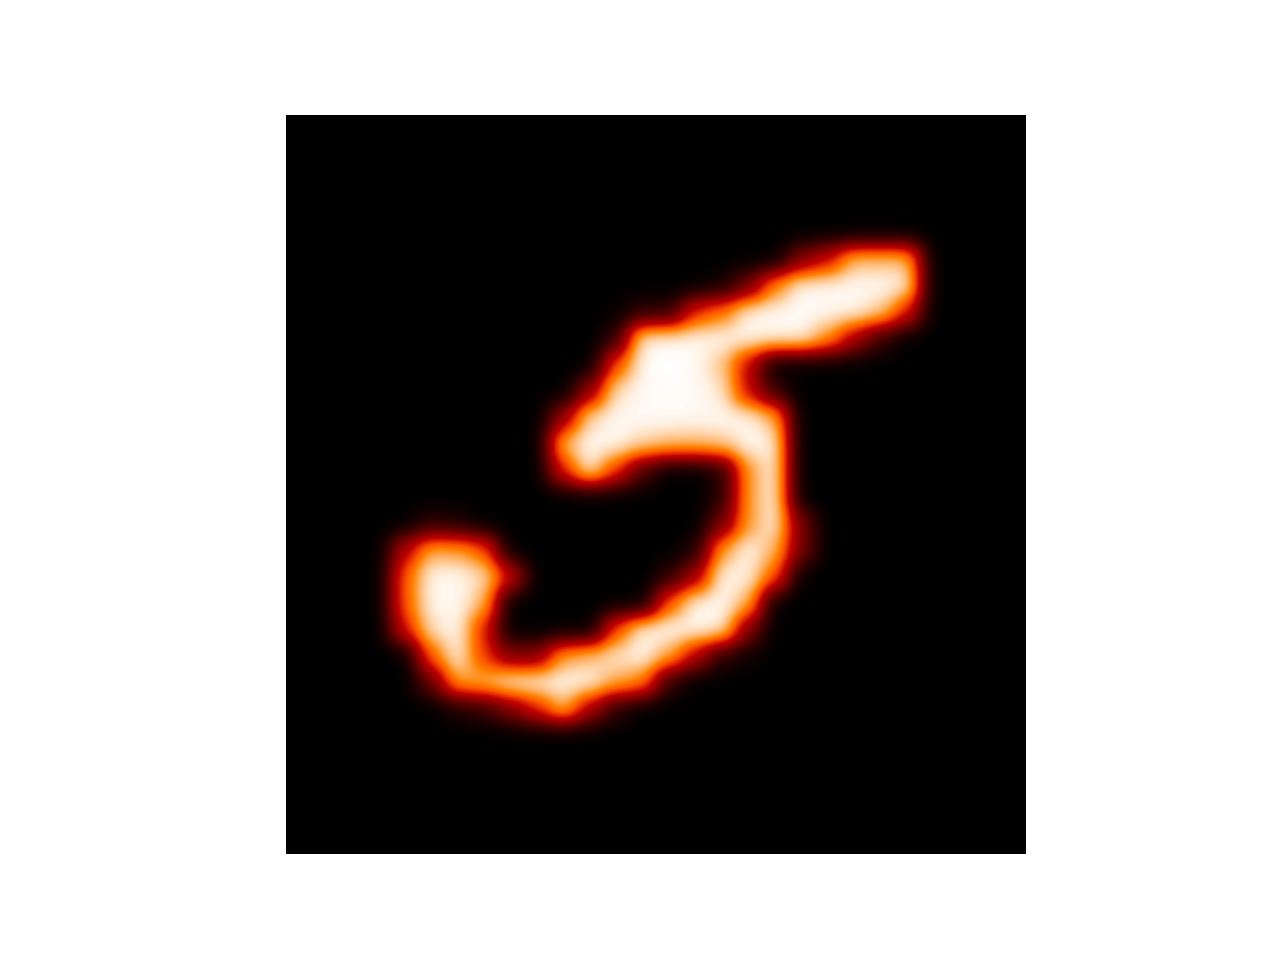

Target: 5.0


In [4]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=plt.get_cmap("gist_heat"), interpolation="gaussian")
plt.axis("off");
print("Target: {}".format(y[36000]))

### Splitting the *test* and *train* datasets

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Shuffling the train dataset
np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a binary classifier
**Fitting a "number 5" classifier with SGD**

In [8]:
# The 'new' targets
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/gerardoduran/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

** Testing the model within the train dataset **

In [11]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### Implementing Cross-Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [10]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)
# Given datsets
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # Copying an instance of the data
    # that has not yet been fitted
    clone_clf = clone(sgd_clf)
    
    # Subset to fit the data
    X_train_fold = X_train[train_index]
    y_train_5_fold = y_train_5[train_index]
    # Subset to test the data
    X_test_fold = X_train[test_index]
    y_test_5_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_fold, y_train_5_fold)
    y_pred = clone_clf.predict(X_test_fold)
    print(sum(y_pred == y_test_5_fold) / len(y_pred))

0.9502
0.96565
0.96495


### Using Cross-Validation Method

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

**One Dumb Classifier**

Testing the accuracy of a classifier that always predict that a given image is **not a five**. This shows that accuracy is not everything. Since the number of 5's is relatively low, it will not be a five most of the times.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never5 = Never5Classifier()
cross_val_score(never5, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

## Confusion Matrices and Cross Validation

In [28]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

| Ref            | Actual    | Predicción |
|----------------|-----------|------------|
| **True Positive**  | Verdadero | Verdadero  |
| **True Negative**  | Falso     | Falso      |
| **False Positive** | Falso     | Verdadero  |
| **False Negative** | Verdadero | Falso      |

## Recall, Precision & the F1 Score
$$
    Recall = \frac{TP}{TP + FN}
$$

$$
    Precision = \frac{TP}{TP + FP}
$$

$$
    F1 = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}}
$$

In [30]:
# Getting Precision v.s. Recall
from sklearn.metrics import recall_score, precision_score
print("Recall:")
print(recall_score(y_train_5, y_train_pred))
print()
print("Precision:")
print(precision_score(y_train_5, y_train_pred))

Recall:
0.801328168235

Precision:
0.768713502035


In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78468208092485547

![precision v.s recall](images/precision_recall_example.png)

**"...in some contexts you mostly care about precision, and in other contexts you really care about recall"**

"For example, if you trained a **classifier to detect videos that are safe for kids**, you would probably prefer a classifier that rejects many good videos **(low recall)** but keeps only safe ones **(high precision)**, rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught)."

### Setting the bar:
Changing the Precision-Recall threshold

In [32]:
# Looking at the current score given by the SGD model
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

In [33]:
threshold = 0
y_some_digit_predict = y_scores > threshold
y_some_digit_predict

array([ True], dtype=bool)

In [34]:
# Setting the threshold at a higher lever
threshold = 200e3
y_some_digit_predict = y_scores > threshold
y_some_digit_predict

array([False], dtype=bool)

### Getting the scores for the training dataset
** Choosing which threshold to use **

In [42]:
y_scores

array([[       0.        ,  -434076.49813641],
       [       0.        , -1825667.15281624],
       [       0.        ,  -767086.76186905],
       ..., 
       [       0.        ,  -867191.25267994],
       [       0.        ,  -565357.11420164],
       [       0.        ,  -366599.16018198]])

In [49]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

y_scores[:,1]

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

<IPython.core.display.Javascript object>


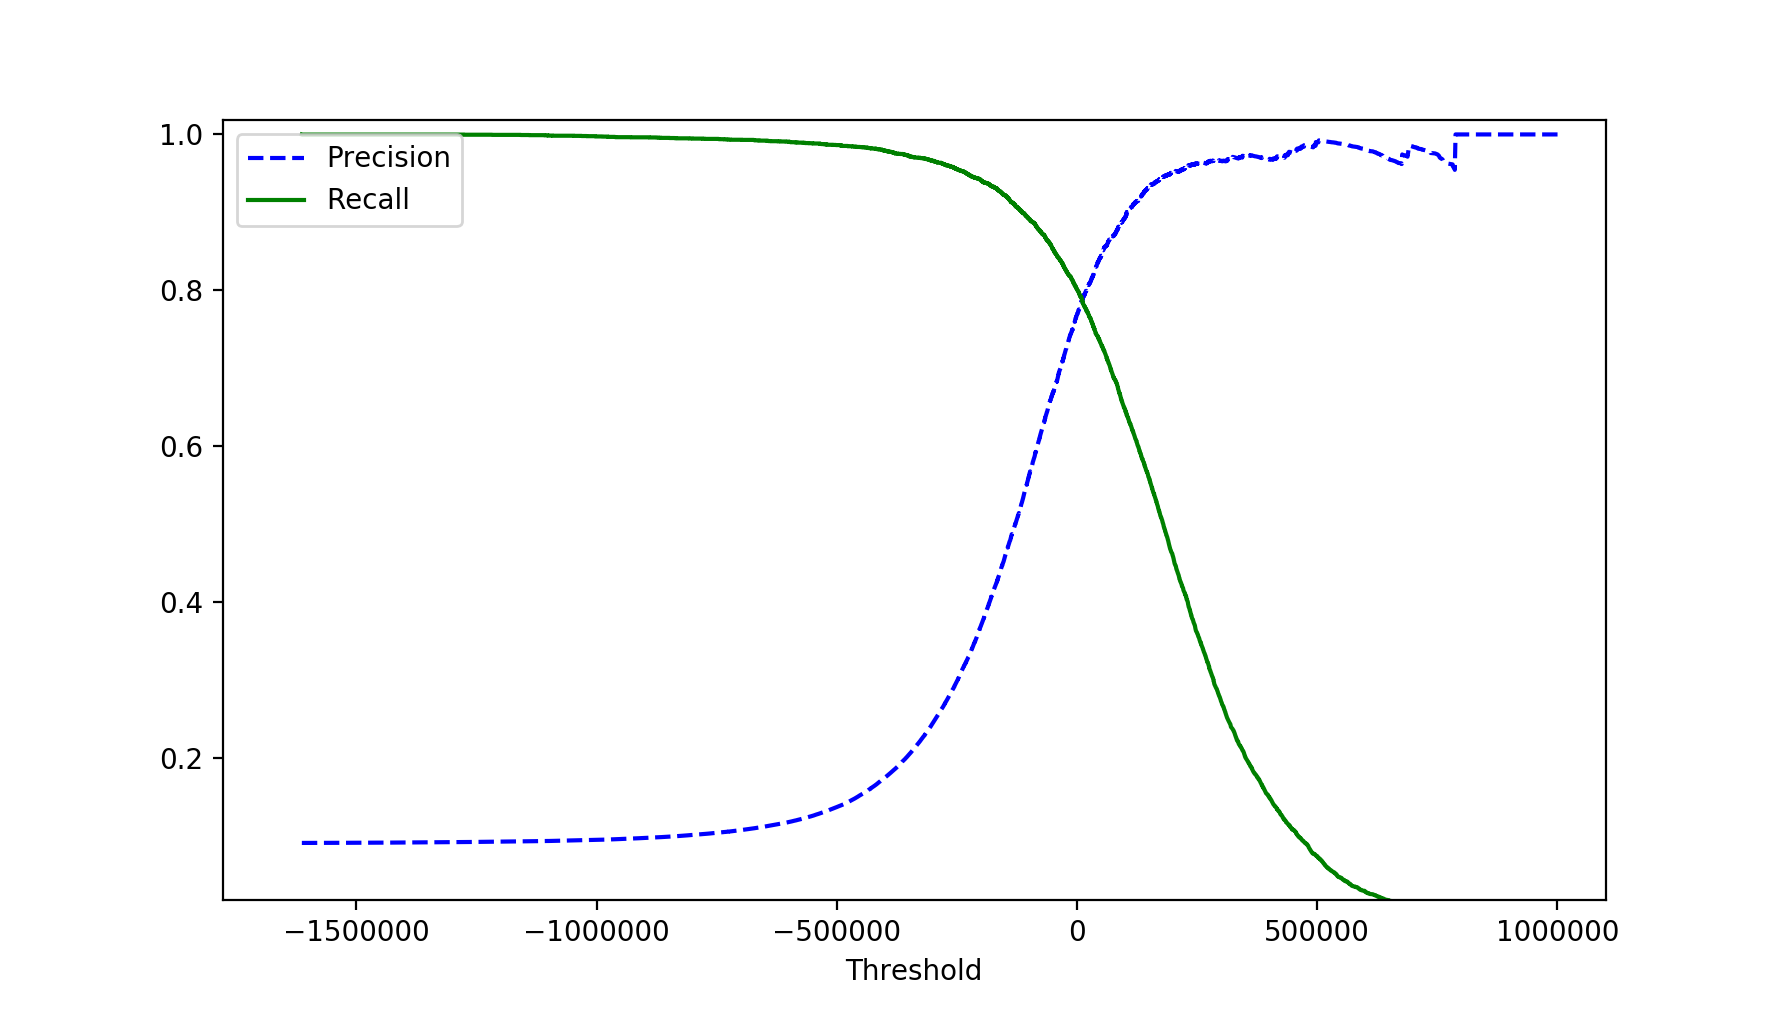

In [50]:
# We first obtain the scores for every element in the training dataset via cross-validation
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# We now compute the precision and recall for all possible thresholds
# using the precision_recall_curve() function
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores[:,1])

# Finally, we plot the decision and recall for the training dataset under different 
# thresholds
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_threshold(precision, recall, thresholds)

Note that **Precision may sometimes go down as the threshold increases**, to see why, look at the figure above and move one digit to the right (starting from the center). The precision moves from 80% (4 out of 5) to 75% (3 out of 4)

### Precision v.s. Recall

In [37]:
plt.plot(precision, recall)
plt.xlabel("Precision")
plt.ylabel("Recall");

NameError: name 'precision' is not defined

Suppose we want, for a project, a 90% precision. Then, we must find the threshold at that value

In [22]:
epsilon = 0.0001
for th, prec in zip(thresholds, precision[:-1]):
    if 0.9 - epsilon < prec < 0.9 + epsilon:
        print("Threshold: {:.2f}".format(th))
        print("Precision: {:.4f}".format(prec))
        print()

Threshold: 103538.07
Precision: 0.8999

Threshold: 103553.93
Precision: 0.8999

Threshold: 103870.54
Precision: 0.9001



In [23]:
threshold_90 = 103553.93
y_train_pred_90 = (y_scores > threshold_90)

print("Precision (at 90%)")
print(precision_score(y_train_5, y_train_pred_90), "\n")

print("Recall")
print(recall_score(y_train_5, y_train_pred_90))

Precision (at 90%)
0.90015560166 

Recall
0.640287769784


# ROC Curve (Receiver Operating Characteristic)
Plotting the False positive rate as a function of the true positive rate

Where
   - **FPR**, is the ratio of negative instances that are incorrectly classified as positive (probability of detection)
   - **TPR**, is another name for the *recall*, or the ratio of correctly classidied instances (probability of a false alarm)
   
That is,
$$
    FPR = \frac{FP}{TP + TN}
$$

and,
$$
    TRP = \frac{TP}{TP + FN}
$$

In [24]:
# Plotting the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

The higher the *True Positive Rate* (recall), the higher will the *False Positive Rate* be.

### The AUC (Area Under the Curve)
A good classifier will have an $AUC \approx 1$, a mediocre classifier will have an $AUC \approx 0.50$ 

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96244965559671547

## Tip: Choosing between the ROC curve v.s. the PR curve

As a rule of thumb, one should choose the **PR curve** to asses the model, "whenever the positive class is rare or when you care more about the false positives than the false negatives,". 

On the contrary, one should choose the **ROC curve** whenever the false positive class is rare or when you care moe about the false negatives than the false positives

## Testing the ROC and PR curves using *Random Forests*

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                   cv=3, method="predict_proba")

In [27]:
# The ROC curve needs scores, not probabilities. To do so, we can
# "choose" our score to be the positive class' probabilities as the score
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_fores = roc_curve(y_train_5, y_scores_forest)

In [28]:
plt.plot(fpr, tpr, ":", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()